In [1]:
# !pip install wordcloud scikit-network datasets
# !pip install tiktoken openai transformers sentence_transformers

# !pip install -U 'spacy[apple]'
# # !pip install -U 'spacy[cuda12x]'

In [2]:
import os
from dotenv import load_dotenv; load_dotenv()

from tqdm.notebook import tqdm
import pickle
import pandas as pd
import numpy as np
import json
import re
import ast
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from datasets import load_dataset

os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
import torch
import spacy; spacy.prefer_gpu()
import tiktoken
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# from vertexai.preview import tokenization
from transformers import pipeline, AutoTokenizer, AutoModel, AutoModelForTokenClassification
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.preprocessing import normalize

import networkx as nx
from transformers.pipelines import pipeline

from src.helpers import preprocessing as preproc
from src.helpers import postprocessing as postproc
from src.helpers.postprocessing import from_list_to_string, safe_json_load
from src.helpers.sentiment_analysis import SentimentModel
from src.topol_modeling import TopolModeling as TOPOL
from src.openai_api import OPENAI_CLIENT, OpenAIEmbedding
from src.openai_api import chat_completion as openai_chat_completion
from src.google_ai_api import GGENAI_CLIENT, GoogleAIEmbedding, AdvancedGoogleAIEmbedding
from src.google_ai_api import chat_completion as google_chat_completion

/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/tig1/miniforge3/envs/topol/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/tig1/miniforge3/envs/topol/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wro

In [3]:
DATA_PATH = os.getenv("DATA_PATH")
OUTPUTS_PATH = os.getenv("OUTPUTS_PATH")

DEVICE = torch.device("mps")
STOP_WORDS = list(ENGLISH_STOP_WORDS)
RANDOM_STATE = 42

# Getting data

In [4]:
dataset = load_dataset("amazon_polarity")
FILES_PREFIX = "amazon_reviews"

# dataset = load_dataset("yelp_review_full")
# FILES_PREFIX = "yelp_reviews"

# dataset = load_dataset("imdb")
# FILES_PREFIX = "imdb_reviews"

# dataset = load_dataset("google_play_store_reviews")
# FILES_PREFIX = "google_play_store_reviews"

In [5]:
X_train = [f"{title} {text}" for title, text in zip(dataset['train']['title'], dataset['train']['content'])]
X_test = [f"{title} {text}" for title, text in zip(dataset['test']['title'], dataset['test']['content'])]

y_train = dataset['train']['label']
y_test = dataset['test']['label']

# X = X_train + X_test
# y = y_train + y_test

data = pd.DataFrame({ 'text': X_train, 'label': y_train })

In [6]:
N_SAMPLE = 5000

df_A = data[data['label'] == 1].sample(N_SAMPLE, random_state=RANDOM_STATE)
df_B = data[data['label'] == 0].sample(N_SAMPLE, random_state=RANDOM_STATE)
df = pd.concat([df_A, df_B], axis=0).reset_index(drop=True)

In [7]:
df

,text,label
0,Perfect Mantra I've been looking for this mant...,1
1,Quality I'm just a little disapointed with the...,1
2,Exceptional murder-mystery writer scores big. ...,1
3,all the prodding questions you never wanted to...,1
4,Best Wok ever I am so glad I bought this wok. ...,1
...,...,...
9995,Doesn't work for me While I applaud the focus ...,0
9996,Beyond Stupid One wonders about all the people...,0
9997,Buyer Be Very Wary The trusted leader in child...,0
9998,I'll bring earplugs to the state fair next yea...,0


# Pre-processing data

##### 1. Data cleaning

In [8]:
entities_to_mask = ["DATE", "TIME", "ORGANIZATION", "NUM", "LOCATION"]
STOP_WORDS += entities_to_mask

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_texts.pickle")
if os.path.exists(fpath):
    print(f"Loading cleaned texts from {fpath}")
    with open(fpath, "rb") as f:
        texts = pickle.load(f)
    print(f"Loaded {len(texts)} texts")
else:
    print(f"Generating cleaned texts for {len(df)} raw texts...")
    texts = []
    for i, row in tqdm(df.iterrows(), total=len(df)):
        cleaned_text = preproc.get_clean_text(row, entities_to_mask=entities_to_mask, max_lenght=5000)
        texts.append(cleaned_text)
    with open(fpath, "wb") as f:
        pickle.dump(texts, f)
    print(f"Saved {len(texts)} cleaned texts to {fpath}.")

df["text"] = texts
del fpath

Loading cleaned texts from /Users/tig1/Programming/TOPOL/data/amazon_reviews_texts.pickle
Loaded 10000 texts


##### 2. Embedding texts

In [ ]:
EMBEDDING_MODEL = OpenAIEmbedding(model="text-embedding-3-small")
# EMBEDDING_MODEL = GoogleAIEmbedding(model="text-embedding-004")
# EMBEDDING_MODEL = AdvancedGoogleAIEmbedding(model='text-embedding-004', task='clustering')
# EMBEDDING_MODEL = SentenceTransformer('intfloat/multilingual-e5-large-instruct', device=DEVICE)

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_embeddings.pickle")
if os.path.exists(fpath):
    print(f"Loading embeddings from {fpath}")
    with open(fpath, "rb") as f:
        embeddings = pickle.load(f)
    print(f"Loaded {len(embeddings)} embeddings")
else:
    print(f"Generating embeddings for {len(df)} text...")
    embeddings = EMBEDDING_MODEL.encode(df["text"].tolist(), fast=False)
    with open(fpath, "wb") as f:
        pickle.dump(embeddings, f)
    print(f"Saved {len(embeddings)} embeddings to {fpath}.")

df["embedding"] = embeddings.tolist()
del fpath

Loading embeddings from /Users/tig1/Programming/TOPOL/data/amazon_reviews_embeddings.pickle
Loaded 10000 embeddings


##### 3. Sentiment Analysis

In [ ]:
sentiment_model = SentimentModel(model_name="tabularisai/multilingual-sentiment-analysis", device=DEVICE)

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_sentiments.pickle")
if os.path.exists(fpath):
    print(f"Loading sentiments from {fpath}")
    with open(fpath, "rb") as f:
        sentiments = pickle.load(f)
    print(f"Loaded {len(sentiments)} sentiments")
else:
    print(f"Generating sentiments for {len(df)} texts...")
    sentiments = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        doc = row['text']
        temp_sentiment = sentiment_model(doc, max_length=512)
        sentiments.append(temp_sentiment)
    with open(fpath, "wb") as f:
        pickle.dump(sentiments, f)
    print(f"Saved {len(sentiments)} sentiments to {fpath}.")

df["sentiment"] = sentiments
df["sentiment_score"] = df["sentiment"].apply(sentiment_model.get_sentiment_score)
del fpath

Device set to use mps


Loading sentiments from /Users/tig1/Programming/TOPOL/data/amazon_reviews_sentiments.pickle
Loaded 10000 sentiments


# TOPOL Modeling

### Prepare data

In [11]:
data_A = df[df["label"] == 1].copy()
data_B = df[df["label"] == 0].copy()

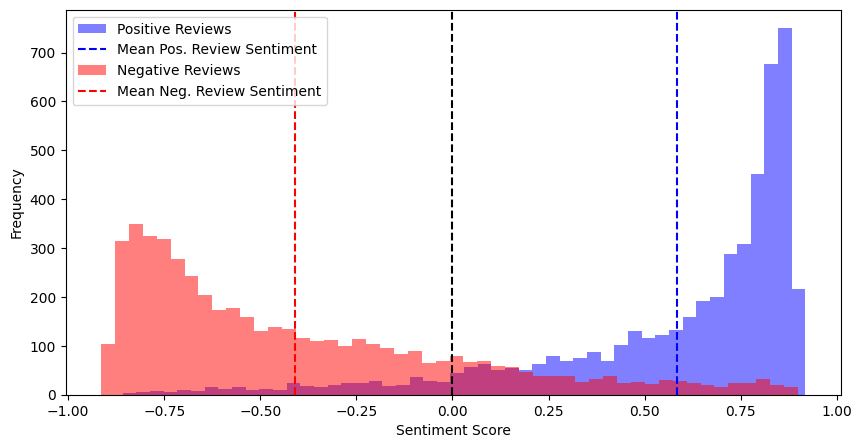

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(data_A["sentiment_score"].values, bins=50, alpha=0.5, label='Positive Reviews', color='blue')
plt.axvline(x=data_A["sentiment_score"].mean(), color='blue', linestyle='--', label='Mean Pos. Review Sentiment')
plt.hist(data_B["sentiment_score"].values, bins=50, alpha=0.5, label='Negative Reviews', color='red')
plt.axvline(x=data_B["sentiment_score"].mean(), color='red', linestyle='--', label='Mean Neg. Review Sentiment')
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()
plt.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_sentiment_score_frequency.pdf"), format="pdf", bbox_inches='tight')
plt.show()

### Prepare UMAP, Leiden and vectorizer model

In [13]:
umap_params = {
    'n_neighbors': 100,
    'min_dist': 0.0,
    'metric': 'cosine',
    'transform_mode': "embedding",
    'random_state': RANDOM_STATE
}

leiden_params = {
    'resolution': 1.5,
    'modularity': 'dugue',
    'random_state': RANDOM_STATE,
}

vectorizer_model = CountVectorizer(stop_words=STOP_WORDS, ngram_range=(1, 2), max_features=10000)

topol_model = TOPOL(
    n_components=50,
    umap_model_params=umap_params,
    leiden_model_params=leiden_params,
    vectorizer_model=vectorizer_model,
    supervised=True,
)

### TOPOL modeling analysis

In [14]:
topol_model.apply_modeling(
    df_A=data_A,
    df_B=data_B,
    n_top_freq_words=20,
    n_repr_docs=10,
    n_top_tf_idf_words=20
)

/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP applied successfully.
Leiden clustering applied successfully.


/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['date', 'location', 'num', 'organization', 'time'] not in stop_words.
  warnings.warn(


Cluster information extracted successfully.


In [15]:
topol_model.dataset_A.cluster_info

,Cluster,Count,Top_Words,Centroid,2D_Centroid,Top_Representative_Docs,Top_Words_TFIDF
0,0,884,"{'album': 661, 'cd': 619, 'date': 470, 'num': ...","[0.010969975832860277, -0.00956266723154865, -...","[-2.2228566312412332, 10.503755383362058]",[One of the best albums of DATE Set aside copy...,"{'cd': 0.41533197940001637, 'love': 0.16344568..."
1,1,375,"{'num': 301, 'great': 221, 'good': 153, 'date'...","[-0.004160364118530803, -0.009276549236606419,...","[5.419112588882446, 7.381257349650065]","[pretty decent Love it, wireless works a lil f...","{'num': 0.28935142376257794, 'great': 0.254170..."
2,2,657,"{'movie': 647, 'great': 317, 'date': 311, 'fil...","[0.002091498675414087, 0.02743958849187121, -0...","[-1.0724732169096147, 6.899012733993646]",[Great Movie This is possibly one of the best ...,"{'date': 0.33194996434119656, 'movie': 0.31350..."
3,3,1056,"{'book': 1598, 'read': 794, 'date': 405, 'stor...","[0.009626297939414117, 0.022107493239962587, -...","[-2.0248910303255827, 4.598665111895763]","[A MOST PLEASANT READ What a pleasure, in DATE...","{'book': 0.37196855539134244, 'read': 0.278976..."
4,4,119,"{'book': 198, 'read': 64, 'good': 44, 'num': 4...","[0.00632185865158265, 0.033157376474661736, -0...","[-2.6708371008143708, 4.236718937128532]",[Sad to see all of these one-star ratings I th...,"{'book': 0.4738220342035632, 'read': 0.1930386..."
5,5,429,"{'date': 224, 'num': 208, 'great': 197, 'good'...","[0.015342238208656277, 0.0018305043261880158, ...","[4.1962527137049985, 5.722301037439378]",[good value My daughter DATE (then six) got th...,"{'date': 0.33392045210503135, 'love': 0.220853..."
6,6,451,"{'book': 855, 'great': 186, 'good': 179, 'date...","[-0.0030579739797956147, 0.015465030595007149,...","[-1.1677268584921725, 3.388652473225562]",[Cool ! Easy to read and best of all - it all ...,"{'book': 0.5860261297231085, 'great': 0.274546..."
7,7,385,"{'num': 238, 'great': 216, 'date': 143, 'use':...","[-0.0033628899451192506, -0.001724323614193549...","[5.721299505156356, 5.86507663541026]",[nothing like a quality utensil! I works as ad...,"{'like': 0.15088613830031133, 'nice': 0.125738..."
8,8,139,"{'date': 89, 'great': 79, 'product': 78, 'num'...","[0.004153796412819568, -0.006370396940406117, ...","[5.127484937088745, 4.997832217662454]",[Great Hair! I have been using this shampoo fo...,"{'date': 0.23629600334841444, 'hair': 0.214814..."
9,9,117,"{'game': 265, 'num': 115, 'great': 54, 'fun': ...","[0.009000975809333166, 0.014916504896444898, -...","[2.042601594558129, 6.1281834117367735]","[Best ""#@&%;!"" Game Ever !! I have to say, I'v...","{'game': 0.6406803414150444, 'best': 0.1637188..."


In [16]:
topol_model.dataset_B.cluster_info

,Cluster,Count,Top_Words,Centroid,2D_Centroid,Top_Representative_Docs,Top_Words_TFIDF
0,0,510,"{'cd': 310, 'album': 293, 'like': 272, 'music'...","[0.0043278797369709415, 0.006608367727305592, ...","[-1.480399962383158, 10.461545989560147]",[NUM well crafted songs does NOT make a great ...,"{'cd': 0.29479114175178583, 'songs': 0.2254285..."
1,1,831,"{'num': 693, 'date': 654, 'product': 354, 'tim...","[-0.01706094067921044, 0.010364430196077964, -...","[5.350158169202139, 7.384219820892481]",[Worthless - Do NOT buy I read the other revie...,"{'date': 0.2529042645876224, 'time': 0.2107535..."
2,2,523,"{'movie': 771, 'film': 266, 'time': 221, 'like...","[-0.011950147607074168, 0.046651840277851325, ...","[-1.6441297529703345, 7.493504520584019]",[I Can't Believe I Watched the Whole Thing Def...,"{'movie': 0.4341706877418103, 'time': 0.200386..."
3,3,61,"{'book': 73, 'read': 29, 'date': 27, 'num': 18...","[0.004479107716059709, 0.030700696158970964, -...","[-2.331316785734208, 4.4100133121990766]",[Professional Editing makes ALL the difference...,"{'book': 0.19187534737090464, 'date': 0.172687..."
4,4,923,"{'book': 1531, 'read': 573, 'just': 339, 'like...","[0.0021425287370323235, 0.04008053715204355, -...","[-2.9700941559197713, 3.964832008337019]",[Couldn't even finish it I couldn't get past p...,"{'book': 0.4448866660896023, 'read': 0.2607956..."
5,5,528,"{'date': 272, 'num': 271, 'product': 152, 'tim...","[0.0016126895974056506, 0.018448350508296327, ...","[4.455727871620294, 5.896649473092773]",[Dissappointed- toy not designed well I bought...,"{'date': 0.3662526136514777, 'legs': 0.1513986..."
6,6,493,"{'book': 965, 'num': 258, 'information': 138, ...","[-0.009222774204930308, 0.0248857992228369, -0...","[-1.3132190037571634, 3.041649305796285]",[Does not deliver what it promises I was disco...,"{'book': 0.6723928473299418, 'waste': 0.107389..."
7,7,371,"{'date': 216, 'num': 204, 'use': 118, 'time': ...","[-0.018170898617061886, 0.022781595751566932, ...","[5.81428936662057, 5.9710996812887265]",[An adjustable disappointment When I first got...,"{'water': 0.24123156440309745, 'num': 0.190709..."
8,8,152,"{'product': 93, 'date': 66, 'like': 62, 'just'...","[-0.012417033933927183, 0.006803296741341718, ...","[5.3483678243662185, 5.187564432621002]",[Not as advertised and reviewed After searchin...,"{'product': 0.376987493497221, 'hair': 0.25132..."
9,9,130,"{'game': 312, 'num': 116, 'games': 59, 'like':...","[-0.00894042072727993, 0.028218956713401265, -...","[2.3568766937806056, 6.097873042179988]",[WHAT A F---ING WASTE OF MY F---ING MONEY!!!!!...,"{'game': 0.5841472606808933, 'num': 0.18521742..."


Drift computed successfully, ready to vizualize.


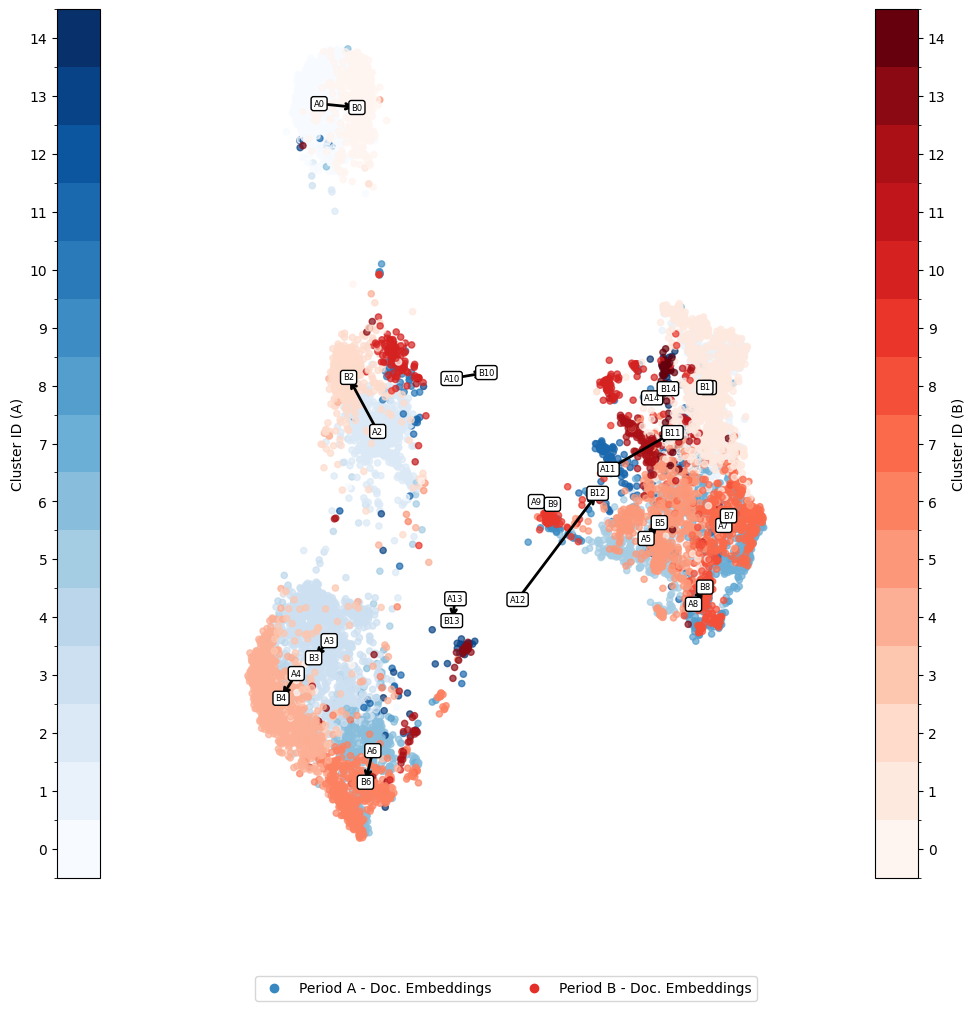

In [17]:
fig, ax = topol_model.vizualize_clusters()
fig.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_topol_clusters.pdf"), format="pdf", bbox_inches='tight')
plt.show(fig, ax)

### Drift analysis

In [18]:
drifts_df = pd.DataFrame.from_dict(topol_model.drifts, orient='index', columns=['x', 'y']).dropna()
drifts_df.index.name = "Cluster"

In [19]:
# Normalize drift vectors to unit length
unit_drifts = normalize(drifts_df.dropna().values, norm='l2')

k = 4
# # KMeans on unit vectors ≈ angular k-means (cosine similarity)
# kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
# drifts_df["labels"] = kmeans.fit_predict(unit_drifts)

# Compute angles in radians
angles = np.arctan2(unit_drifts[:, 1], unit_drifts[:, 0])   # range [-pi, pi]
angles = (angles + 2 * np.pi) % (2 * np.pi)                 # convert to [0, 2pi]
sector_size = 2 * np.pi / k                                 # Define number of angular sectors
labels = np.floor(angles / sector_size).astype(int)         # Assign each angle to a sector
drifts_df["labels"] = labels

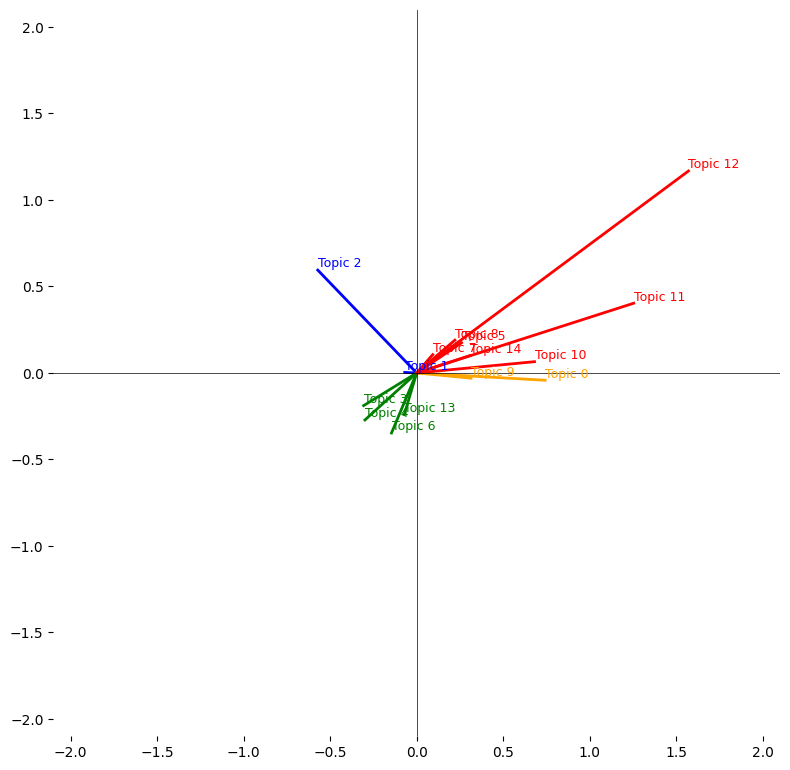

In [20]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink', 'brown', 'gray']

fig, ax = plt.subplots(figsize=(8, 10))

for topic_id, row in drifts_df.iterrows():
    x, y, label_id = row['x'], row['y'], int(row['labels'])
    color = colors[label_id]
    ax.plot([0, x], [0, y], color=color, linewidth=2, label=f"Topic {topic_id}")
    ax.text(x, y, f"Topic {topic_id}", fontsize=9, color=color, ha='left', va='bottom')

lim = 2.1
ax.set_aspect('equal', 'box')
ax.set_xlim(-lim, lim); ax.set_ylim(-lim, lim)
ax.axhline(0, color='black', linewidth=0.5); ax.axvline(0, color='black', linewidth=0.5)
ax.set_frame_on(False)
fig.tight_layout()

fig.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_topol_drifts.pdf"), format="pdf", bbox_inches='tight')
plt.show()

### Drift explainability

In [22]:
fpath = os.path.join(DATA_PATH, "narrative_dimensions.pickle")
if os.path.exists(fpath):
    with open(fpath, "rb") as f:
        NARRATIVE_DIMENSIONS = pickle.load(f)
    print(f"Loaded {len(NARRATIVE_DIMENSIONS)} narrative dimensions from {fpath}")
else:
    raise FileNotFoundError(f"File {fpath} not found. Please generate narrative dimensions first.")
del fpath

Loaded 123 narrative dimensions from /Users/tig1/Programming/TOPOL/data/narrative_dimensions.pickle


In [23]:
fpath = os.path.join(DATA_PATH, "prompt_template.txt")
if os.path.exists(fpath):
    with open(fpath, "r") as f:
        PROMPT_TEMPLATE = f.read()
    print(f"Loaded prompt template from {fpath}")
else:
    raise FileNotFoundError(f"Prompt template file not found at {fpath}")
del fpath

Loaded prompt template from /Users/tig1/Programming/TOPOL/data/prompt_template.txt


In [24]:
def generate_narrative_comparison_prompt(text1, text2):
    prompt = PROMPT_TEMPLATE.replace("#####DIMENSIONS_LIST#####", from_list_to_string(NARRATIVE_DIMENSIONS))
    prompt = prompt.replace("#####TEXT1#####", text1)
    prompt = prompt.replace("#####TEXT2#####", text2)
    return prompt

In [25]:
# chat_completion_func = openai_chat_completion
chat_completion_func = google_chat_completion

In [29]:
# zipped_representative_docs = list(zip(
#     topol_model.dataset_A.cluster_info['Top_Representative_Docs'],
#     topol_model.dataset_B.cluster_info['Top_Representative_Docs']
# ))
# top_n_docs = 3  # Number of top documents to compare per cluster

# for i, (top_docs_A, top_docs_B) in tqdm(enumerate(zipped_representative_docs), total=len(zipped_representative_docs)):

#     # Get the representative documents for each cluster
#     if top_n_docs is not None:
#         text1 = from_list_to_string(top_docs_A[:top_n_docs])  # Take top N docs for cluster A
#         text2 = from_list_to_string(top_docs_B[:top_n_docs])  # Take top N docs for cluster B
#     else:
#         text1 = from_list_to_string(top_docs_A)
#         text2 = from_list_to_string(top_docs_B)

#     # Generate the prompt for the LLM
#     prompt = generate_narrative_comparison_prompt(text1, text2)
#     response = chat_completion_func(prompt)

#     # Dynamic response variable (you can also use a list or dict instead of naming each one)
#     var_name = f"response_row{i}"
#     globals()[var_name] = response

#     # Parse the JSON response safely
#     parsed_llm_out = safe_json_load(response)

#     # Save to file
#     with open(f"{OUTPUTS_PATH}/{FILES_PREFIX}_ND_row{i}.json", "w", encoding="utf-8") as f:
#         json.dump(parsed_llm_out, f, ensure_ascii=False, indent=2)

#     print(f"✅ Processed and saved row {i}")